In [ ]:
! pip install sklearn
! pip install sewar

  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=13da0eb876a68b942345a2a8946067fb2670c37c246b079607fd826aaebb0770
  Stored in directory: /root/.cache/pip/wheels/7a/38/6b/d066cfcb2b1c1c9b059b9ce1bdc4803b469359214e8dad4e3e
Successfully built sewar


In [ ]:
import torch
import numpy as np
import os
import re
import cv2
import math
import random
from matplotlib import pyplot as plt
import albumentations as A
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision
from sklearn import metrics
import sewar

ModuleNotFoundError: ignored

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')
drive_dir = '/content/drive/MyDrive/Programming/Machine_Learning/AviaVision/'
os.chdir(drive_dir)

Mounted at /content/drive/


In [ ]:
test_idx = [0, 30, 60]
train_idx = [i for i in range(0,62) if (i not in test_idx) and (i % 5 == 0)]

### Get masks from json files

In [ ]:
import json

all_idx = test_idx + train_idx
for idx in all_idx:
    with open(f'{drive_dir}SegAnnotation/{idx}.json') as json_inp:
      data = json.load(json_inp)
      inp_img = cv2.imread(f'{drive_dir}RawPhotos/{idx}.png')
      x,y,_ = inp_img.shape
      img = np.zeros((x,y), dtype=np.uint8)

      # draw contours on image using set of points of json file
      points =  np.array(data['shapes'][0]['points'], dtype=np.int32)
      river = img.copy()
      cv2.polylines(river, [points], True, 255, 1)
      
      # find externa contours
      cntrs = cv2.findContours(river, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
      cntrs = cntrs[0] if len(cntrs) == 2 else cntrs[1]

      # get a single contour of img
      c = cntrs[0]
      mask = img.copy()
      cv2.drawContours(mask, [c], 0, 255, -1)

      # show the result
      # plt.imshow(mask, cmap='gray')
      cv2.imwrite(f'{drive_dir}SegAnnotation/{idx}.png', mask)

## **Dataset class for images**

0, 30, 60 - test photos

other - train

In [ ]:
class RiverImg(Dataset):
  def __init__(self, data_type='train'):
    self.data_type = data_type
    self.transform = transforms.Compose([transforms.ToTensor()])

  def __len__(self):
    return len(test_idx) if self.data_type=='test' else len(train_idx)

  # I NEED TO EXTRACT MASK FROM JSON FILES

  def __getitem__(self, inp_idx):
    normalize = A.Compose([
      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0)
    ])

    resize = A.Compose([
      A.LongestMaxSize(max_size=572, interpolation=1, always_apply=False, p=1),
      A.Resize(572, 572, p=1.0)
    ])

    idx = train_idx[inp_idx] if self.data_type=='train' else test_idx[inp_idx]

    img = cv2.imread(f'{drive_dir}RawPhotos/{idx}.png')
    # img = resize(image=img)['image']
    img_norm = normalize(image=img)['image']
    # img_norm = np.moveaxis(img_norm, 2, 0)

    mask = cv2.imread(f'{drive_dir}SegAnnotation/{idx}.png', cv2.IMREAD_GRAYSCALE)
    # mask = resize(image=mask)['image']
    # mask_norm = normalize(image=mask)['image']
    mask = mask/255
    mask = mask.astype(np.float32)
    # print(mask.shape)
    plt.imshow(mask, cmap='gray')

    return self.transform(img_norm), self.transform(mask), idx

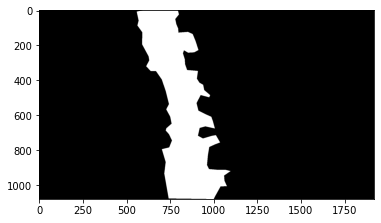

In [ ]:
train_data = RiverImg('train')
test_data = RiverImg('test')
train_loader = DataLoader(dataset=train_data, batch_size=1, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=True, num_workers=2)
_,_,_ = train_data.__getitem__(3)

### Load and train model

In [ ]:
# Unet = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5, out_channels=1)
model = torchvision.models.segmentation.fcn_resnet50(pretrained=False, num_classes=1, pretrained_backbone=True)
# model = torch.nn.Sequential(*(list(model.children())[:-1]))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
!nvidia-smi

Fri Apr 29 15:03:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=0)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
epochs = 100

model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
over_loss = []
Jacard = []

for ep in range(1, epochs+1):
  epoch_loss = 0
  running_loss = 0
  epoch_metrics = []
  for (inputs, masks, idxs) in train_loader:
    inputs = inputs.to(device)
    masks = masks.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs['out'])
    # img = outputs.squeeze().cpu().detach().numpy()
    # plt.imshow(img, cmap='gray')

    # print(outputs['out'].dtype)
    epoch_loss = criterion(outputs, masks)
    # backpropogating when on train data
    epoch_loss.backward()
    optimizer.step()
    running_loss += epoch_loss.item()
    # print(running_loss)
    # epoch_metrics.append(sewar.uqi(outputs.unsqueeze(0).cpu().detach().numpy(), 
    #                          masks.unsqueeze(0).cpu().detach().numpy()))
    torch.cuda.empty_cache()
  res = sum(epoch_metrics)/len(train_data)
  over_loss.append(running_loss/train_data.__len__())
  print(f'Epoch: {ep}, Loss: {epoch_loss}, UQI: {res}')
  torch.save(model.state_dict(), f'{drive_dir}FCN_Resnet50_100_x')

Epoch: 1, Loss: 0.06637854129076004, UQI: 0.0
Epoch: 2, Loss: 0.06017438694834709, UQI: 0.0
Epoch: 3, Loss: 0.06624283641576767, UQI: 0.0
Epoch: 4, Loss: 0.056974127888679504, UQI: 0.0
Epoch: 5, Loss: 0.06317785382270813, UQI: 0.0
Epoch: 6, Loss: 0.05591936409473419, UQI: 0.0
Epoch: 7, Loss: 0.05720379948616028, UQI: 0.0
Epoch: 8, Loss: 0.056279636919498444, UQI: 0.0
Epoch: 9, Loss: 0.05659683048725128, UQI: 0.0
Epoch: 10, Loss: 0.05996600538492203, UQI: 0.0
Epoch: 11, Loss: 0.05517593026161194, UQI: 0.0
Epoch: 12, Loss: 0.05880684033036232, UQI: 0.0
Epoch: 13, Loss: 0.05178601294755936, UQI: 0.0
Epoch: 14, Loss: 0.050323281437158585, UQI: 0.0
Epoch: 15, Loss: 0.049791451543569565, UQI: 0.0
Epoch: 16, Loss: 0.05332786217331886, UQI: 0.0
Epoch: 17, Loss: 0.048988670110702515, UQI: 0.0
Epoch: 18, Loss: 0.054927580058574677, UQI: 0.0
Epoch: 19, Loss: 0.047758638858795166, UQI: 0.0
Epoch: 20, Loss: 0.05027007684111595, UQI: 0.0
Epoch: 21, Loss: 0.0451328419148922, UQI: 0.0
Epoch: 22, Loss:

KeyboardInterrupt: ignored

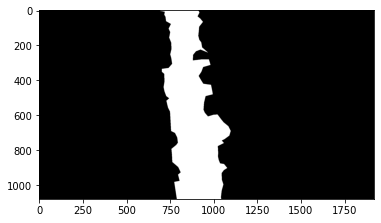

In [ ]:
img, mask, _ = test_data.__getitem__(0)

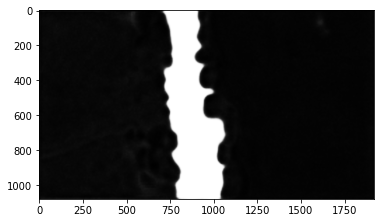

In [ ]:
plt.imshow(torch.sigmoid(model(img.unsqueeze(0).to(device))['out']).squeeze(0).cpu().detach().numpy()[0], cmap='gray')

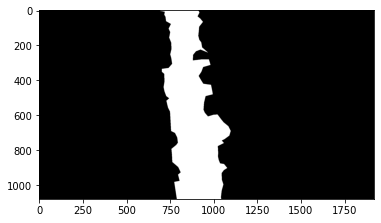

In [ ]:
plt.imshow(mask.cpu().detach().numpy()[0], cmap='gray')

### **Save masks**

In [ ]:
model.load_state_dict(torch.load( f'{drive_dir}FCN_Resnet50_100_x'))

<All keys matched successfully>

In [ ]:
normalize = A.Compose([
  A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0)
])

transform = transforms.Compose([transforms.ToTensor()])

for i in range(62):
  img = cv2.imread(f'{drive_dir}RawPhotos/{i}.png')
  # plt.imshow(img[:,:,::-1])
  img = normalize(image=img)['image']
  img = transform(img).unsqueeze(0)
  img = img.to(device)
  print(img.size())
  
  mask = torch.sigmoid(model(img)['out']).squeeze(0).cpu().detach().numpy()[0] * 255
  cv2.imwrite(f'{drive_dir}Masks/{i}.png', mask)

torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Si